In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

DATA_PATH = 'data/'

with open(DATA_PATH+'X_test_tokens.txt', 'r') as file: # data with tokens
    X_test = file.read().split('^')[:-1]

with open(DATA_PATH+'y_pred.pkl', 'rb') as file: # predictions for the dataset x_test
    y_pred = pickle.load(file)
    
y_test = np.loadtxt(DATA_PATH+'y_test.txt', dtype=int) # true one-hot labels

# # we dont need x_test and Y_test for now, but you can check them
# with open(DATA_PATH+'Y_test_tokens.txt', 'r') as file:
#     Y_test = file.read().split('^')[:-1]
# x_test = np.loadtxt(DATA_PATH+'x_test.txt', dtype=int)

lens    = np.array([len(X_test[i].split(',')) for i in range(len(X_test))])  # number of tokens
is_shot = np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1)             # true predictions of the model

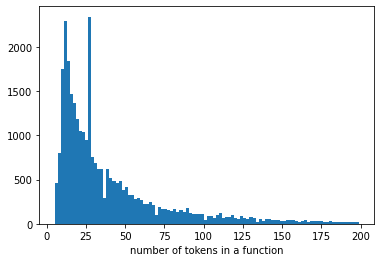

In [12]:
# distribution of the longths of functions
plt.hist(lens[lens<200], bins = 100)
plt.xlabel('number of tokens in a function');

divide the whole sample into three subsamples of approximately equal length,\
these samples correspond to the smaller number of tokens in the function, the near-median number and the larger number.

In [10]:
# cut 'outliers' using 0.97-quantile
low, mid, high = np.quantile(lens, [0.32,0.65, 0.97])

mask_low = lens<=low
mask_mid = (lens>low) & (lens<=mid)
mask_high = (lens>mid) & (lens<high)
print('sizes of subsamples:',sum(mask_low), sum(mask_mid), sum(mask_high))

sizes of subsamples: 9981 10149 9894


Now, to test the hypotheses that the average accuracy is the same\
let's aggregate the subsamples by batch of pieces and on each of them we will calculate accuracy

In [11]:
def get_accs(mask, batch):
    accs  = [sum(is_shot[mask][i:i+batch])/batch for i in range(0, sum(mask)-batch, batch)]
    resid = sum(mask)%batch
    accs.append(sum(is_shot[mask][-resid:])/resid)
    return accs

batch = 500
low_accs, mid_accs, high_accs = get_accs(mask_low, batch), get_accs(mask_mid, batch), get_accs(mask_high, batch)
print('Aggregated sample sizes:',len(low_accs), len(mid_accs), len(high_accs))
print('Mean accuracy:',round(np.mean(low_accs),3), round(np.mean(mid_accs),3), round(np.mean(high_accs),3))

Aggregated sample sizes: 20 21 20
Mean accuracy: 0.748 0.846 0.767


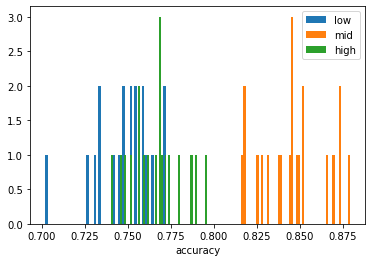

In [6]:
# нарисуем распределения accuracy для наглядности
ax = plt.subplot()
ax.hist(low_accs,  bins = 50, label = 'low')
ax.hist(mid_accs,  bins = 50, label = 'mid')
ax.hist(high_accs, bins = 50, label = 'high')
plt.xlabel('accuracy')
plt.legend()
plt.show()

Since we can say very little about the distribution of the predicted results,\
we will use the nonparametric Mann-Whitney U rank test for hypothesis H0: the distribution of samples is the same.\
It is often used as a test for the difference in expectation between samples.

In [7]:
from scipy.stats import mannwhitneyu
_, p1 = mannwhitneyu(low_accs, mid_accs,  method="asymptotic")
_, p2 = mannwhitneyu(mid_accs, high_accs, method="asymptotic")
_, p3 = mannwhitneyu(low_accs, high_accs, method="asymptotic")
p1, p2, p3 # all p-values < 0.05 => we can reject H0

(4.576059818966736e-08, 4.5822145927833645e-08, 0.0016088594459584514)

thus we obtained that for the given model and for the selected data the result is statistically significant:\
with more tokens per function accuracy is higher, but with too many tokens accuracy decreases.